In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
input_length = 168
output_length = 24

show_graph = True

In [3]:
# Original Group

# model_paths = ["Save_File/Grouped_model_0601/A1.ckpt",
#                 "Save_File/Grouped_model_0601/A2.ckpt",
#                 "Save_File/Grouped_model_0601/A3.ckpt",
#                 "Save_File/Grouped_model_0601/A4.ckpt",
#                 "Save_File/Grouped_model_0601/B1.ckpt",
#                 "Save_File/Grouped_model_0601/B2.ckpt",
#                 "Save_File/Grouped_model_0601/B3.ckpt",
#                 "Save_File/Grouped_model_0601/B4.ckpt",
#                 "Save_File/Grouped_model_0601/C1.ckpt",
#                 "Save_File/Grouped_model_0601/C2.ckpt",
#                 "Save_File/Grouped_model_0601/C3.ckpt",
#                 "Save_File/Grouped_model_0601/C4.ckpt",
#                 "Save_File/Grouped_model_0601/D1.ckpt",
#                 "Save_File/Grouped_model_0601/D2.ckpt",
#                 "Save_File/Grouped_model_0601/D3.ckpt",
#                 "Save_File/Grouped_model_0601/D4.ckpt",
#                 "Save_File/Grouped_model_0601/D5.ckpt",
#                 "Save_File/Grouped_model_0601/E1.ckpt",
#                 "Save_File/Grouped_model_0601/E2.ckpt",
#                 "Save_File/Grouped_model_0601/E3.ckpt",
#                 "Save_File/Grouped_model_0601/E4.ckpt"]

# group_name = [
#     "A1", "A2", "A3", "A4", 
#     "B1", "B2", "B3", "B4",
#     "C1", "C2", "C3", "C4", 
#     "D1", "D2", "D3", "D4", "D5", 
#     "E1", "E2", "E3", "E4"
# ]

# group = [
#     [4],[10, 11, 12, 41],[34],[40, 42]
#     ,[6, 8, 13, 17, 25, 26, 48, 53, 55, 56],[7, 18],[27, 57],[35, 46, 47]
#     ,[1, 31],[9, 32],[3],[33]
#     ,[2, 14, 22, 23, 37, 44, 52, 54],[15],[38, 58, 43],[29, 39],[45]
#     ,[5, 59],[16, 24],[19, 20, 21, 49, 50, 51],[28, 30, 36, 60]
# ]

# data_path = "./Refined_Data/Grouped_Data/Input_Data.csv"

# Group 2

model_paths = ["Save_File/Grouped2_model_0602/A1.ckpt",
                "Save_File/Grouped2_model_0602/A2.ckpt",
                "Save_File/Grouped2_model_0602/A3.ckpt",
                "Save_File/Grouped2_model_0602/A4.ckpt",
                "Save_File/Grouped2_model_0602/A5.ckpt",
                "Save_File/Grouped2_model_0602/A6.ckpt",
                "Save_File/Grouped2_model_0602/A7.ckpt",
                "Save_File/Grouped2_model_0602/B1.ckpt",
                "Save_File/Grouped2_model_0602/B2.ckpt",
                "Save_File/Grouped2_model_0602/B3.ckpt",
                "Save_File/Grouped2_model_0602/B4.ckpt",
                "Save_File/Grouped2_model_0602/B5.ckpt",
                "Save_File/Grouped2_model_0602/C1.ckpt",
                "Save_File/Grouped2_model_0602/C2.ckpt",
                "Save_File/Grouped2_model_0602/C3.ckpt",
                "Save_File/Grouped2_model_0602/C4.ckpt",
                "Save_File/Grouped2_model_0602/D1.ckpt",
                "Save_File/Grouped2_model_0602/D2.ckpt",
                "Save_File/Grouped2_model_0602/D3.ckpt",
                "Save_File/Grouped2_model_0602/D4.ckpt",
                "Save_File/Grouped2_model_0602/D5.ckpt",
                "Save_File/Grouped2_model_0602/D6.ckpt",
                "Save_File/Grouped2_model_0602/E1.ckpt",
                "Save_File/Grouped2_model_0602/E2.ckpt",
                "Save_File/Grouped2_model_0602/E3.ckpt",
                "Save_File/Grouped2_model_0602/E4.ckpt",
                "Save_File/Grouped2_model_0602/E5.ckpt"]

group_name = [
    "A1", "A2", "A3", "A4", "A5", "A6", "A7",
    "B1", "B2", "B3", "B4", "B5",
    "C1", "C2", "C3", "C4", 
    "D1", "D2", "D3", "D4", "D5", "D6", 
    "E1", "E2", "E3", "E4", "E5"
]

group = [
    [4],[11, 12],[34],[40],[10],[42],[41]
    ,[6, 8, 13, 17, 26, 48, 53, 55, 56],[7, 18],[27, 57],[35, 46, 47],[25]
    ,[1, 31],[9, 32],[3],[33]
    ,[2, 14, 22, 37, 44, 52, 54],[15],[38, 58, 43],[29, 39],[45],[23]
    ,[5],[16, 24],[19, 20, 21, 49, 50, 51],[28, 30, 36, 60],[59]
]

data_path = "./Refined_Data/Grouped_Data/Input_Data2.csv"

In [4]:
dataframes = pd.read_csv(data_path, parse_dates = ["date_time"])

dataframes['num']     =   dataframes['num'].apply(str)
dataframes['Week']    =   dataframes['Week'].apply(str)
dataframes['24Hour']  =   dataframes['24Hour'].apply(str)
dataframes['holiday'] =   dataframes['holiday'].apply(str)
dataframes['Weekend'] =   dataframes['Weekend'].apply(str)
dataframes['energy_group'] = dataframes['energy_group'].apply(str)

random_choice = random.randrange(2,13)

start_point = -168 * random_choice - 1
duration = 168

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

all_smape = []
part_smape = [[] for i in range(len(group_name))]

now group : A1


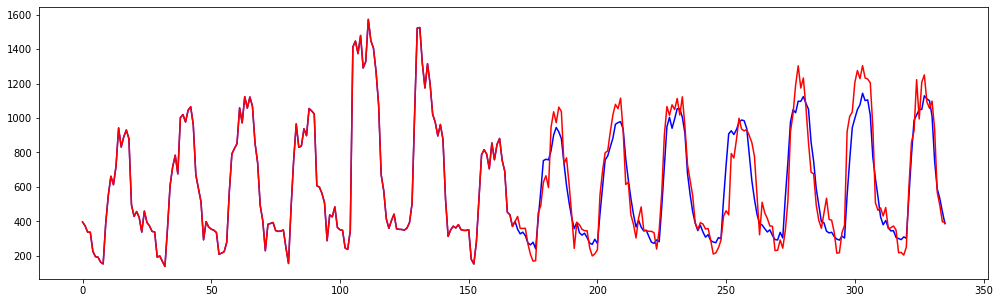

building : 4, score : 15.242957951471347
now group : A2


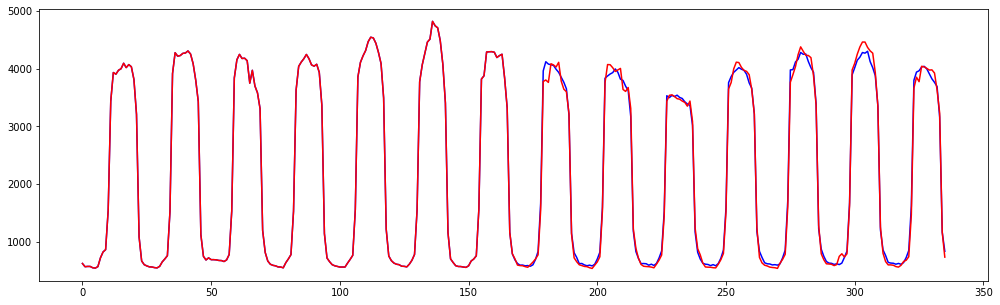

building : 11, score : 4.567237096335496


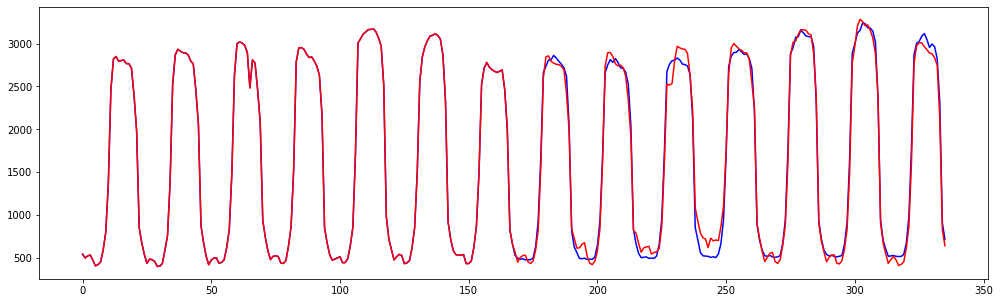

building : 12, score : 8.042926915354471
now group : A3


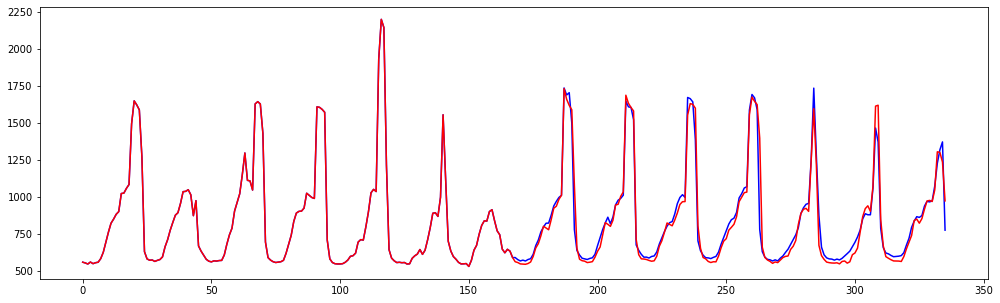

building : 34, score : 4.798859117295338
now group : A4


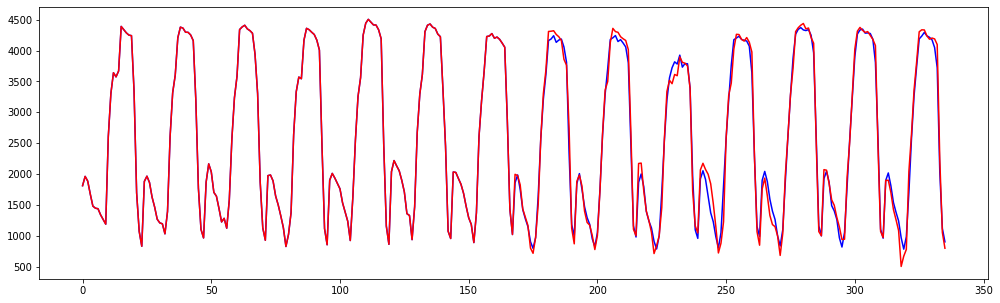

building : 40, score : 5.921582730208915
now group : A5


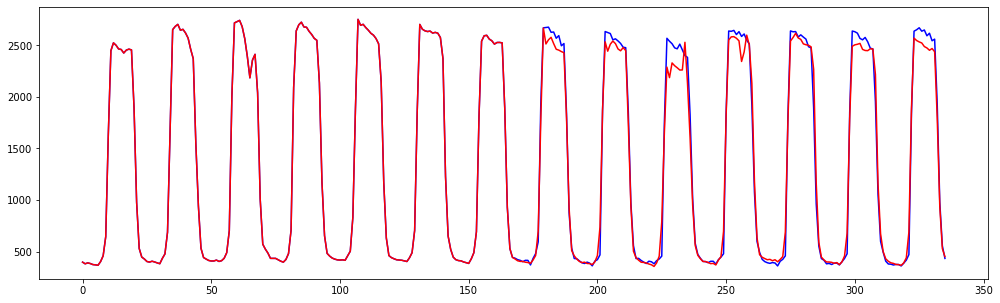

building : 10, score : 5.792112468552347
now group : A6


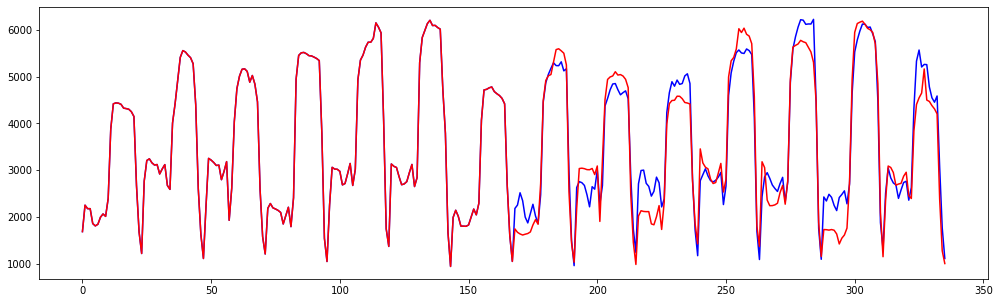

building : 42, score : 11.828601289346386
now group : A7


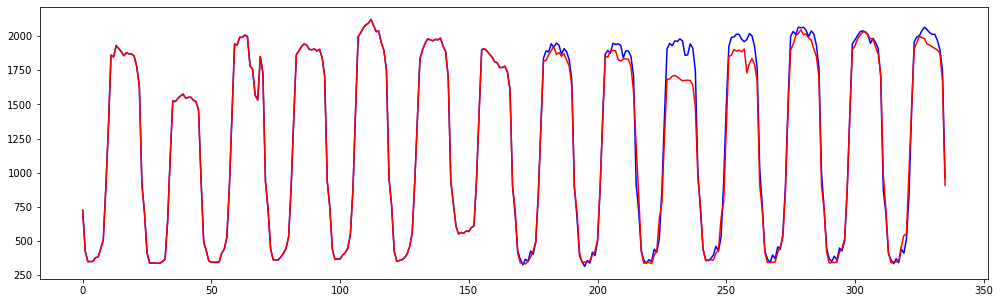

building : 41, score : 5.684657299250416
now group : B1


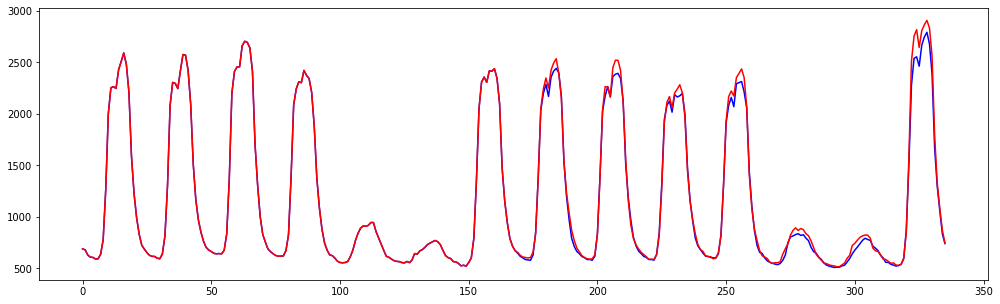

building : 6, score : 3.1404547997455317


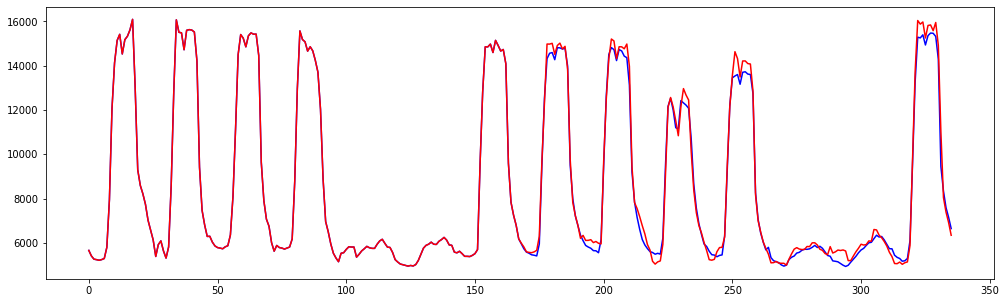

building : 8, score : 3.317124432500122


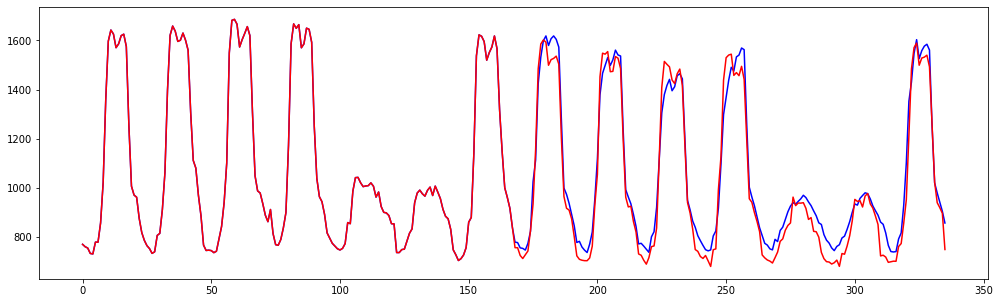

building : 13, score : 5.273194391356612


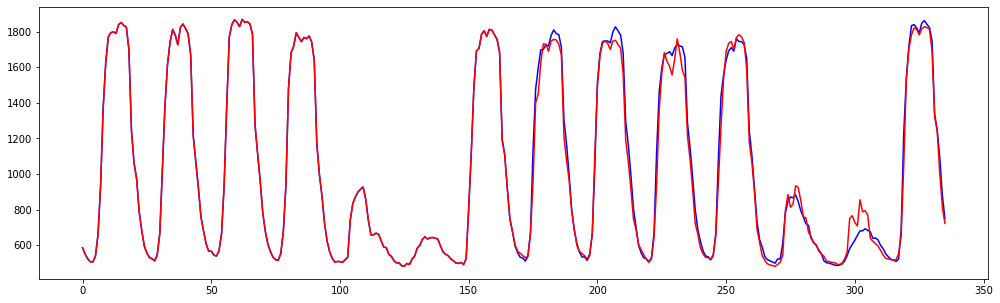

building : 17, score : 4.311165137157679


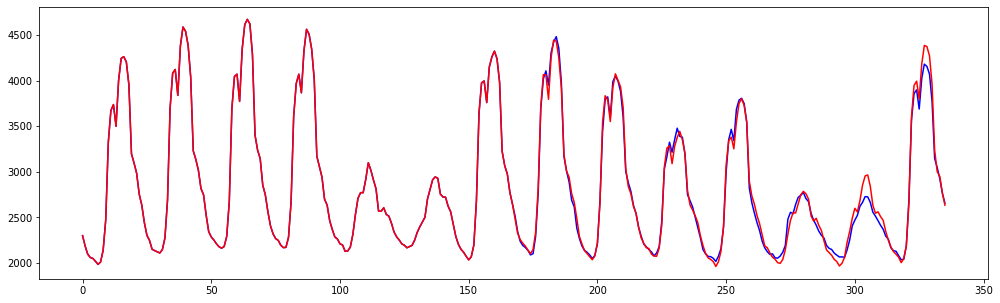

building : 26, score : 1.9254060499241932


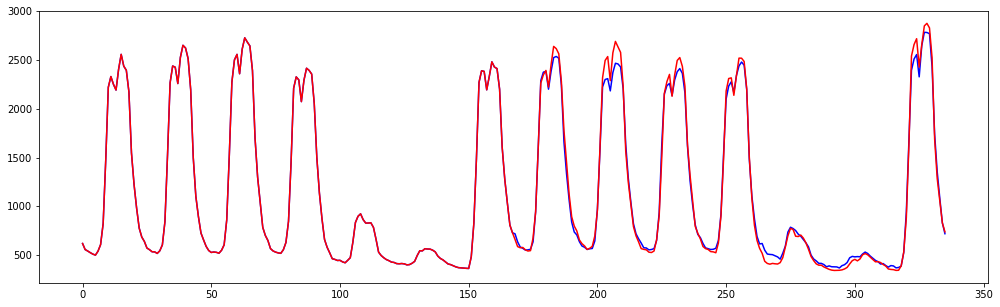

building : 48, score : 4.849908158914591


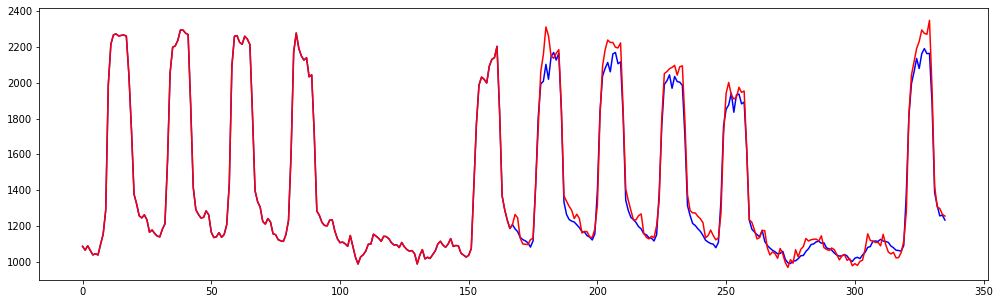

building : 53, score : 2.985226973382446


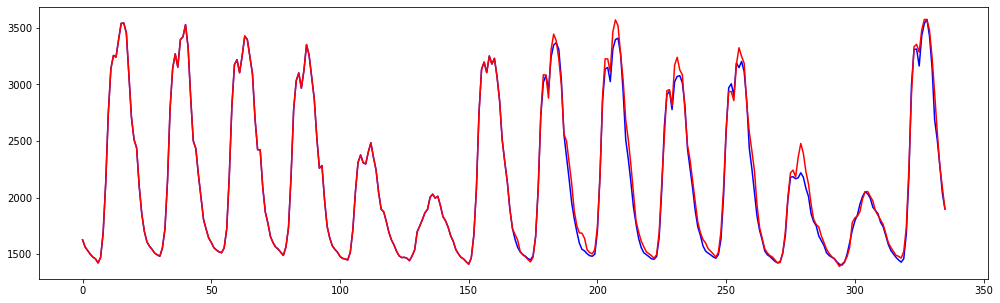

building : 55, score : 2.498414337274871


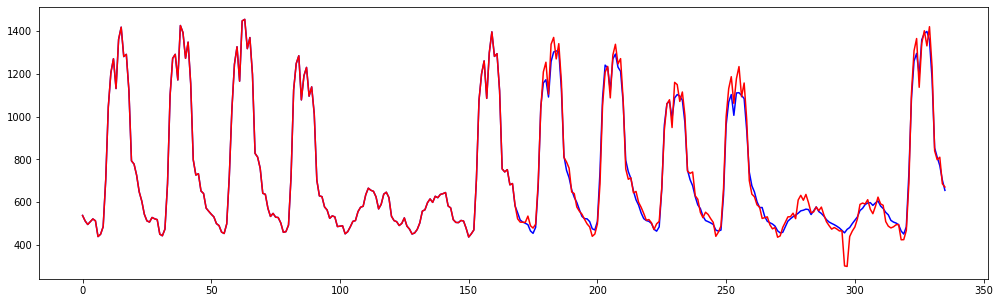

building : 56, score : 4.291868694251932
now group : B2


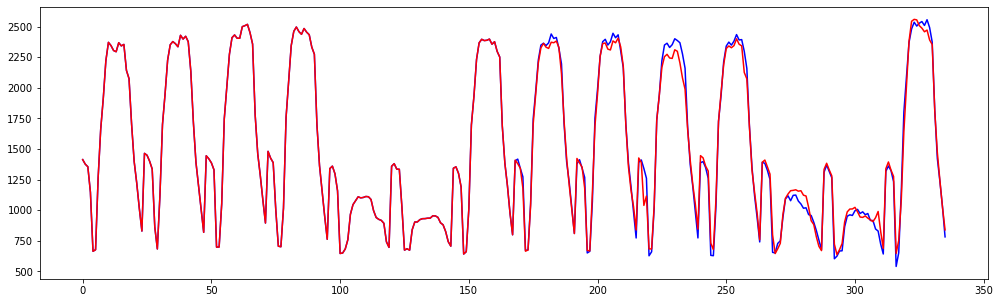

building : 7, score : 3.743248625714141


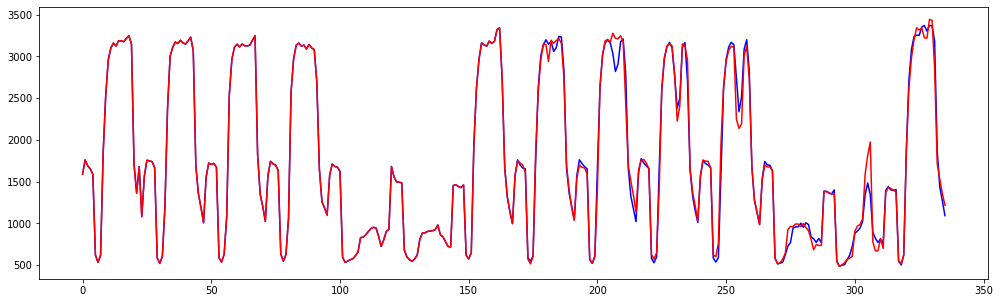

building : 18, score : 4.64523642580198
now group : B3


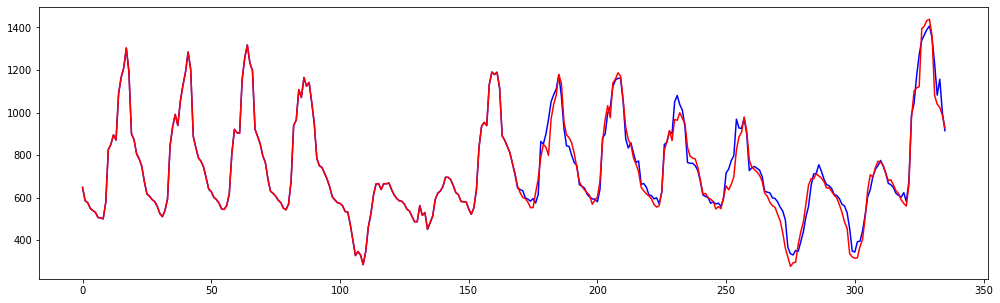

building : 27, score : 5.298918646876949


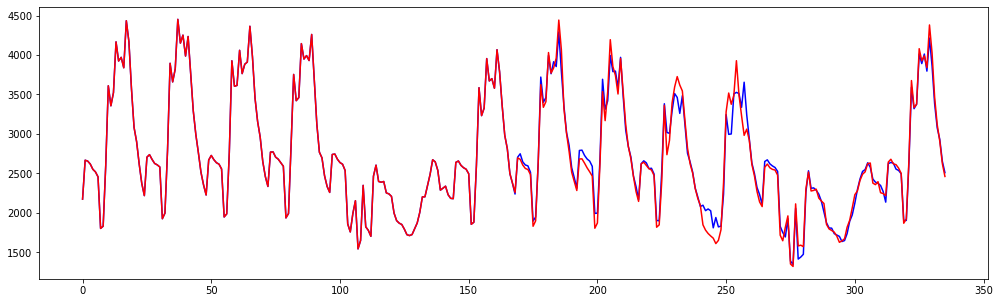

building : 57, score : 3.154218817095335
now group : B4


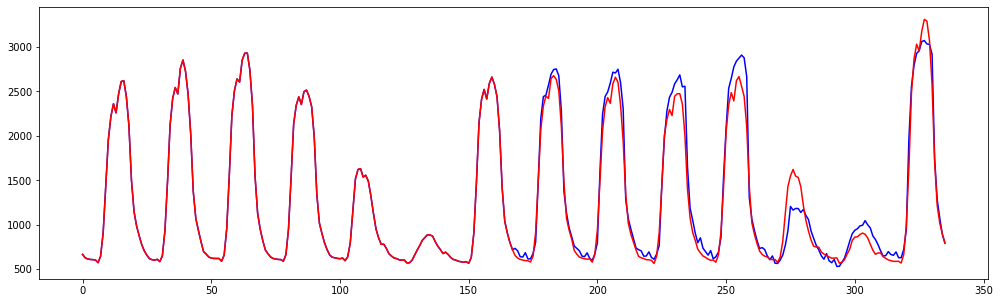

building : 35, score : 8.731406604713857


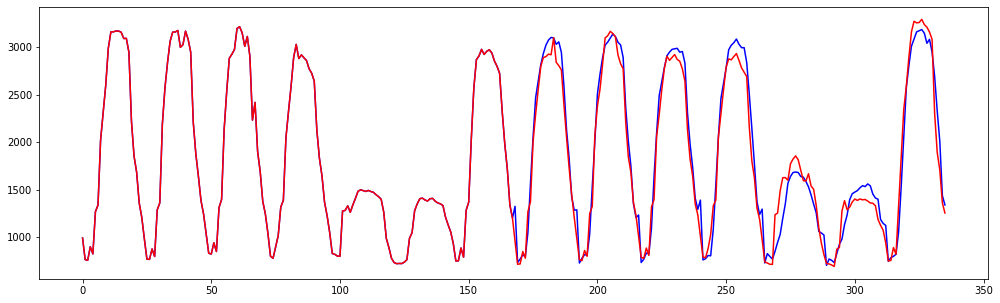

building : 46, score : 8.07504612887338


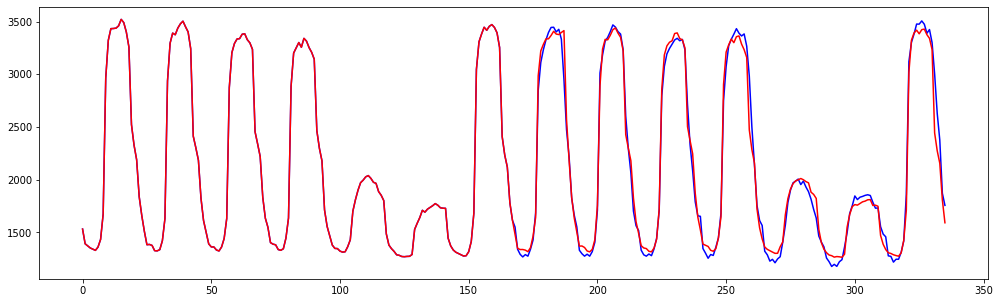

building : 47, score : 3.4051539584210655
now group : B5


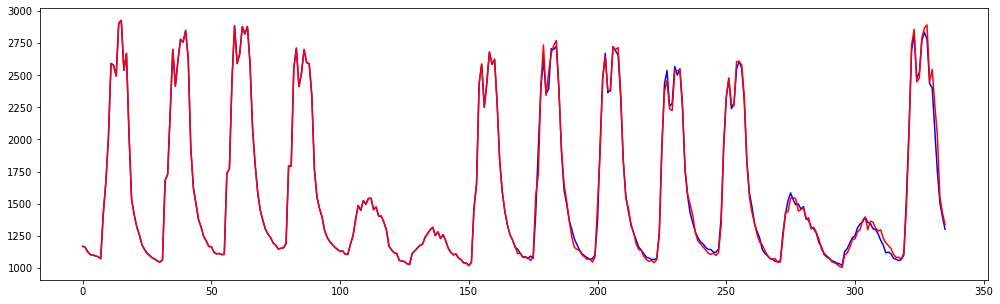

building : 25, score : 2.052841885006671
now group : C1


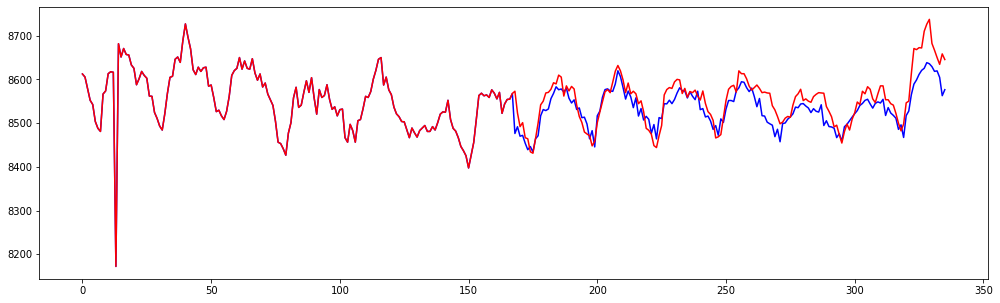

building : 1, score : 0.3042955755902333


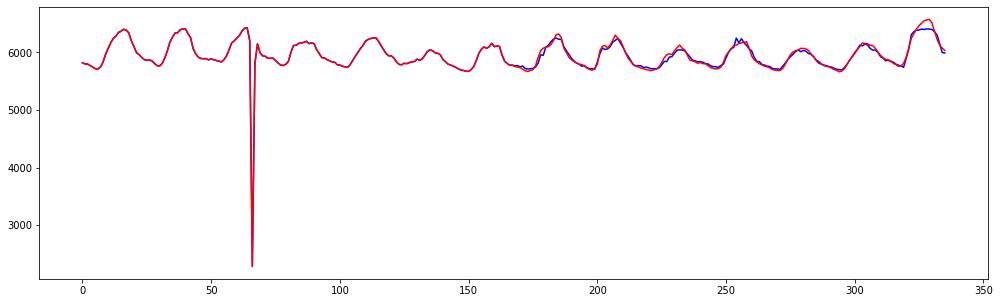

building : 31, score : 0.5583402415630192
now group : C2


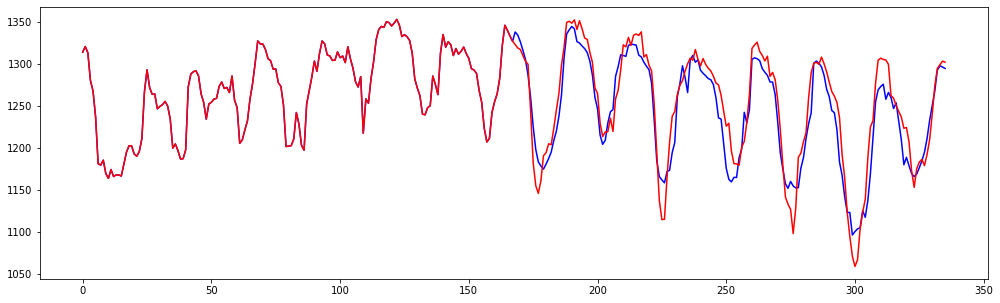

building : 9, score : 1.5517754899410672


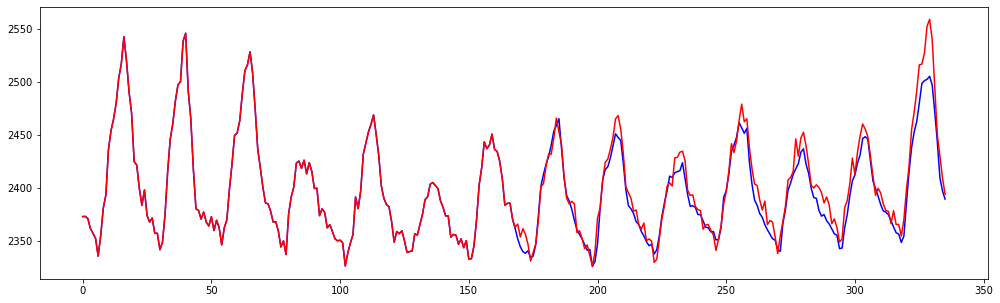

building : 32, score : 0.4059452359882123
now group : C3


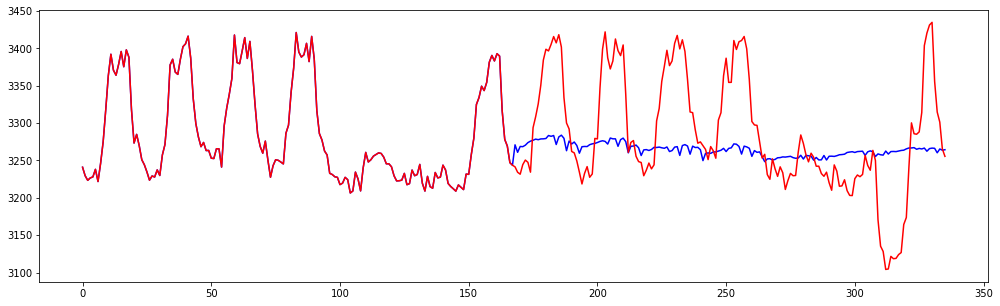

building : 3, score : 1.784253615769069
now group : C4


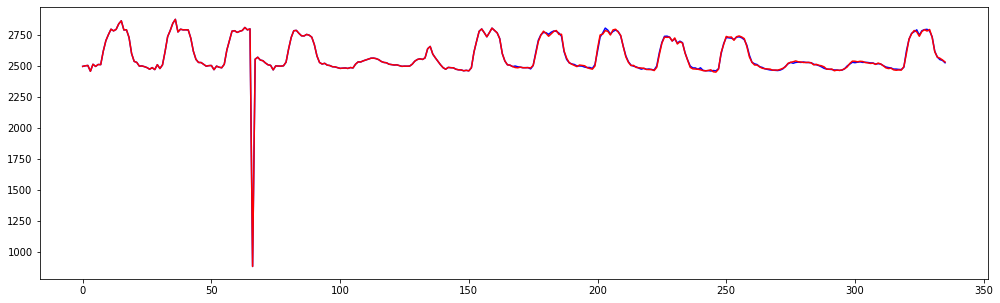

building : 33, score : 0.23419757808050892
now group : D1


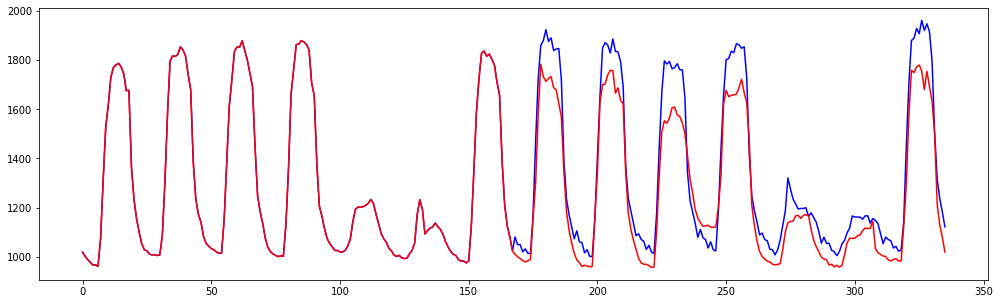

building : 2, score : 6.991403618064309


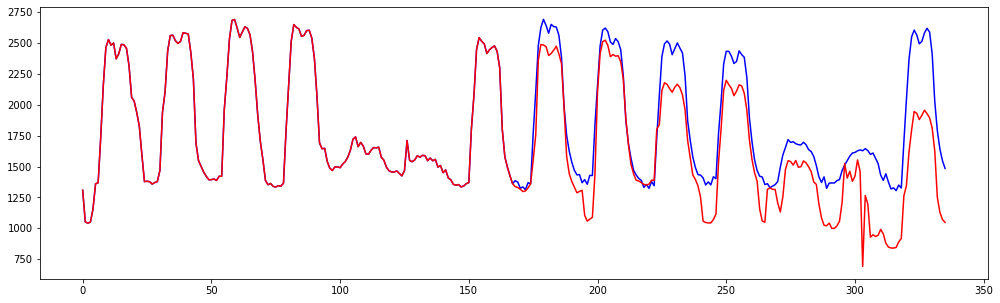

building : 14, score : 16.52347139984587


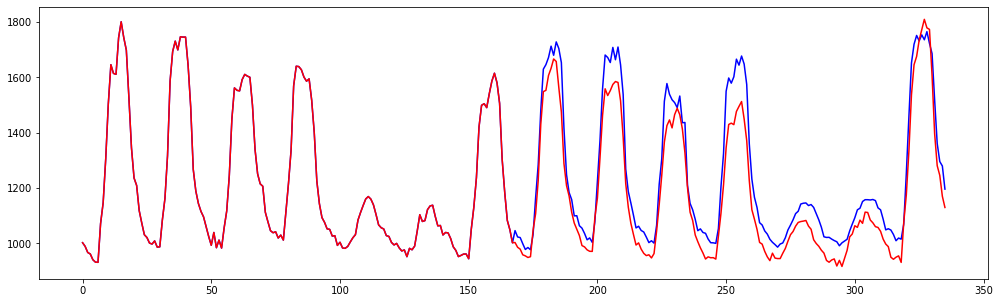

building : 22, score : 5.962358212734829


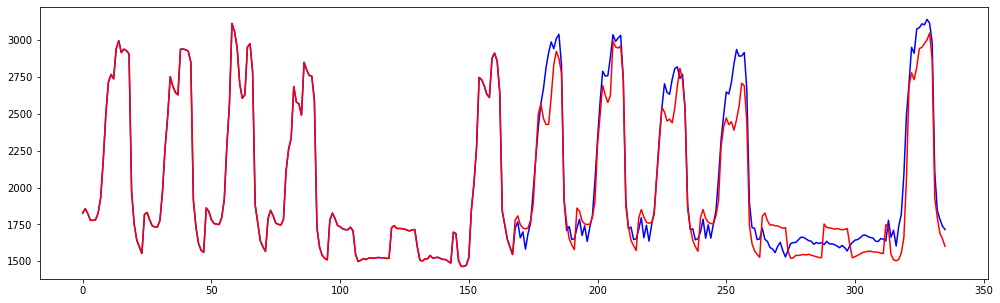

building : 37, score : 5.81208172977671


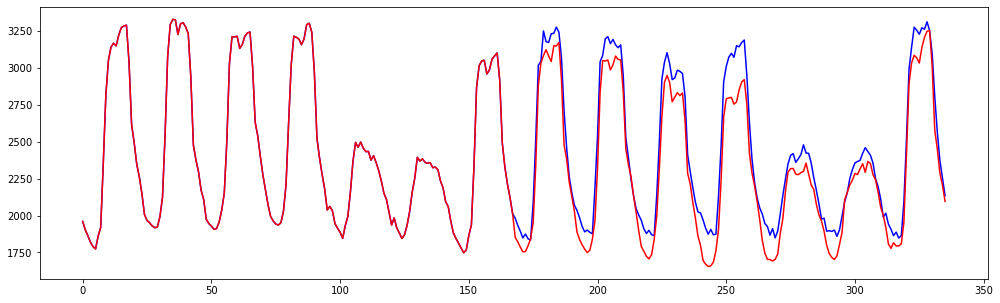

building : 44, score : 5.480269948427495


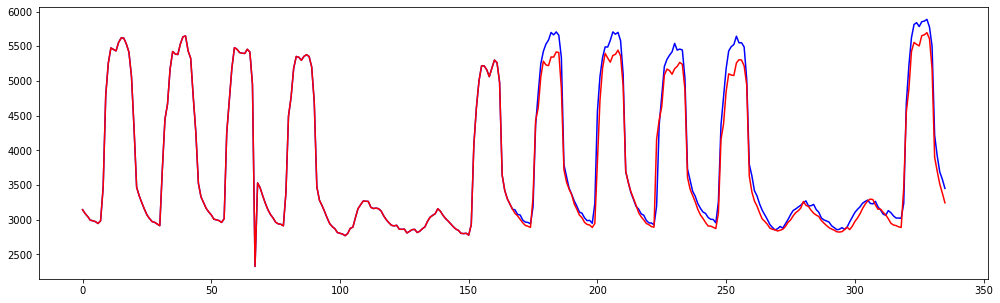

building : 52, score : 3.4053113435106974


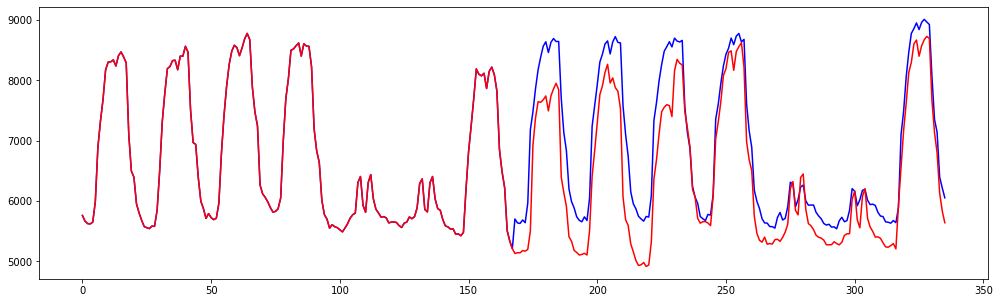

building : 54, score : 7.23469712036728
now group : D2


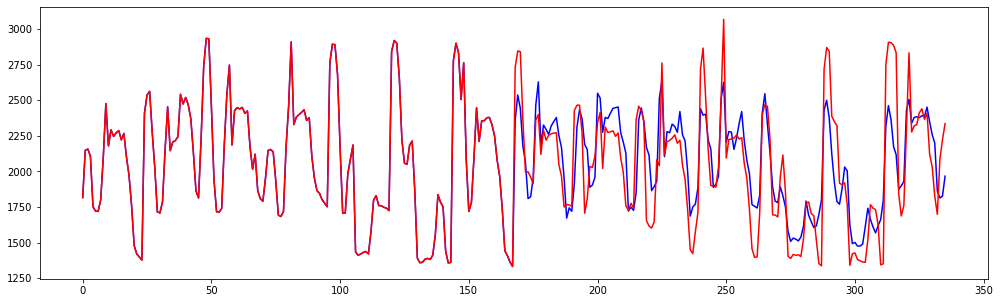

building : 15, score : 9.171708560466264
now group : D3


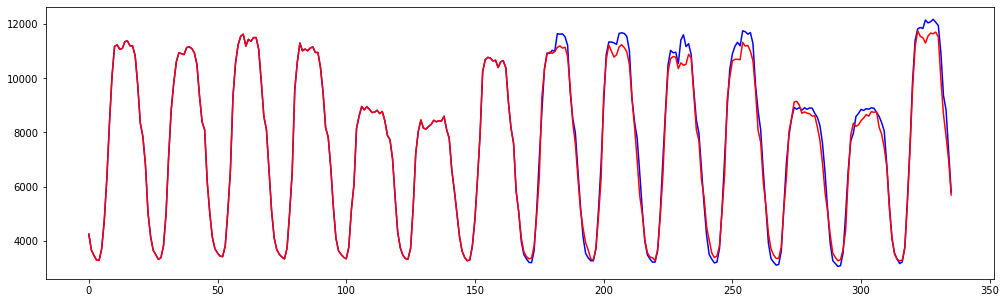

building : 38, score : 4.238310766540156


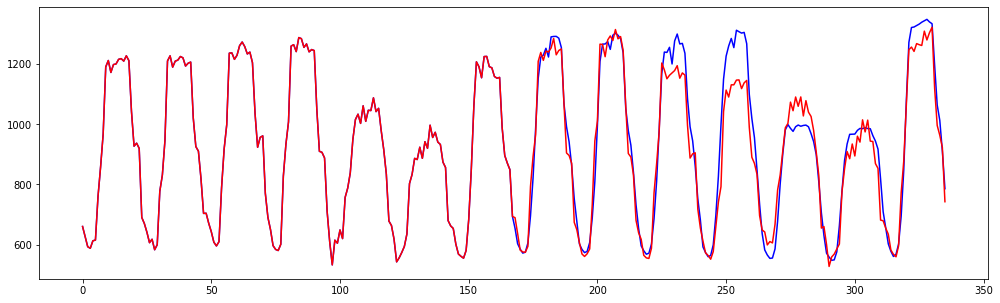

building : 58, score : 5.148484282421891


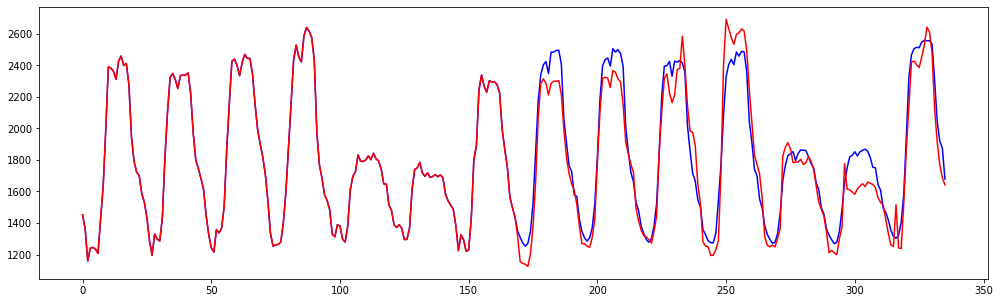

building : 43, score : 5.708001634820125
now group : D4


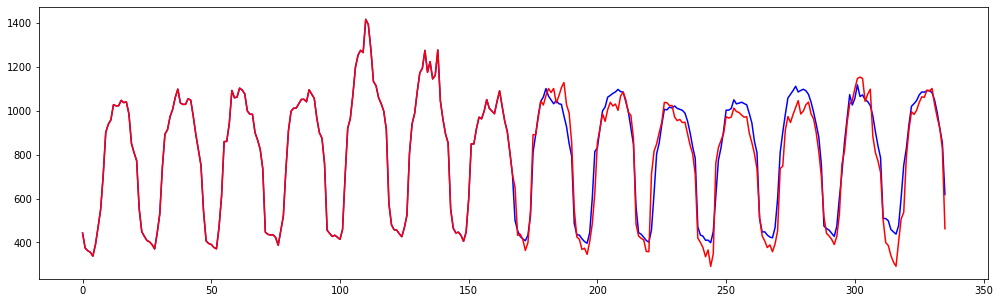

building : 29, score : 8.353122537693421


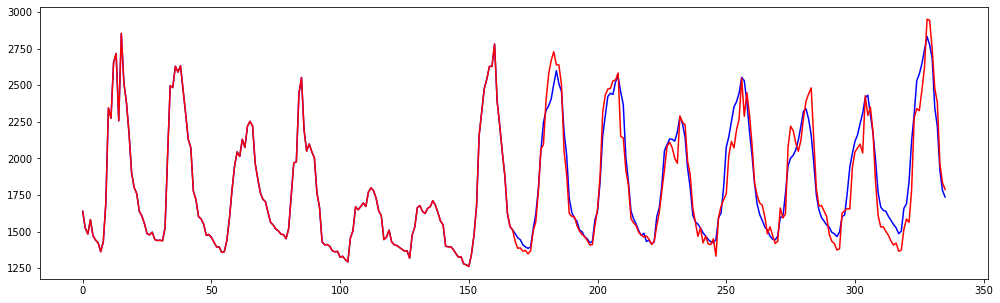

building : 39, score : 4.508166763886037
now group : D5


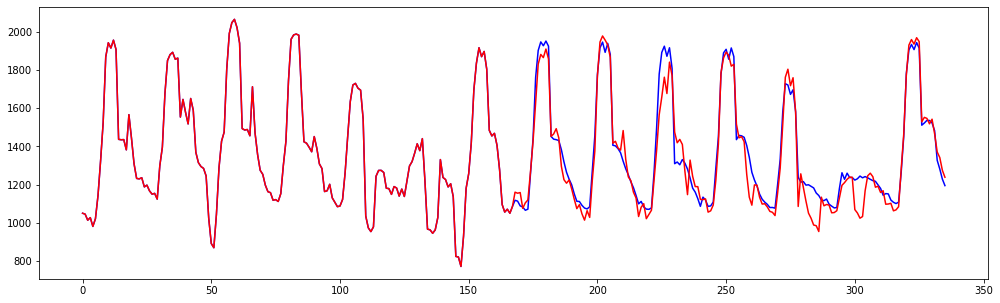

building : 45, score : 4.090946218233237
now group : D6


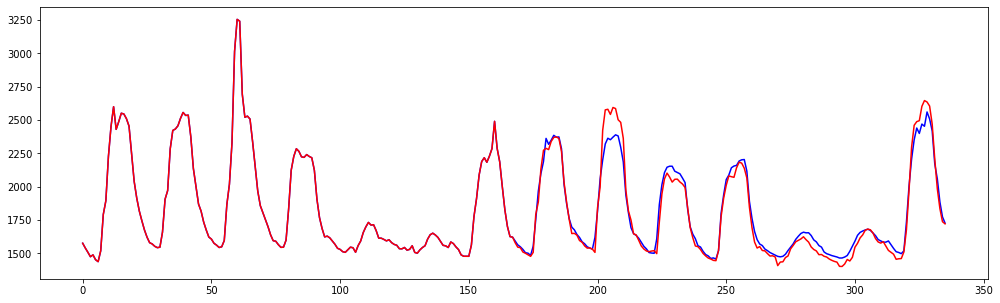

building : 23, score : 2.5023808675206656
now group : E1


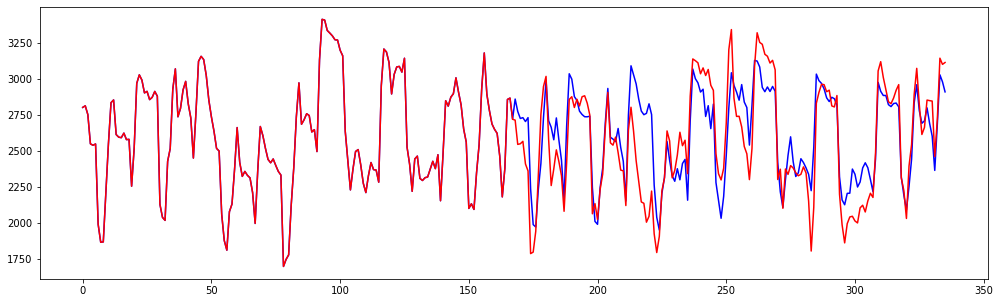

building : 5, score : 6.649616093855119
now group : E2


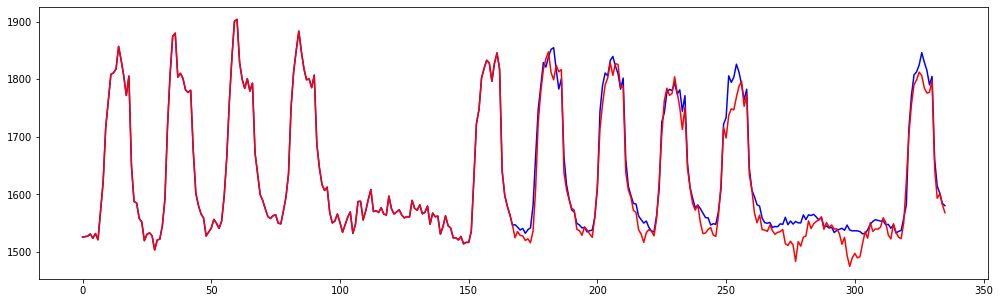

building : 16, score : 1.1052037663214995


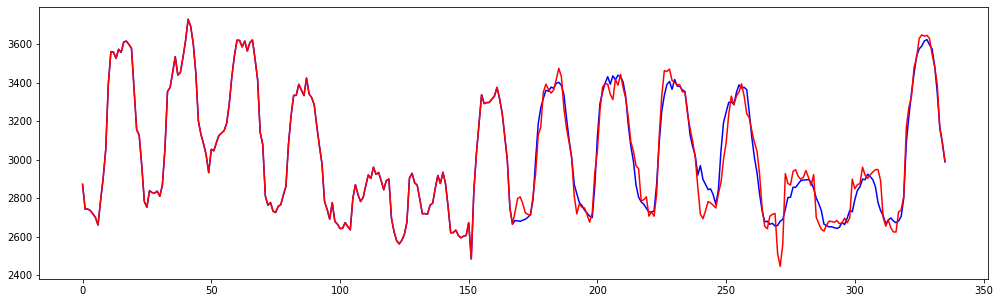

building : 24, score : 1.7502268887841514
now group : E3


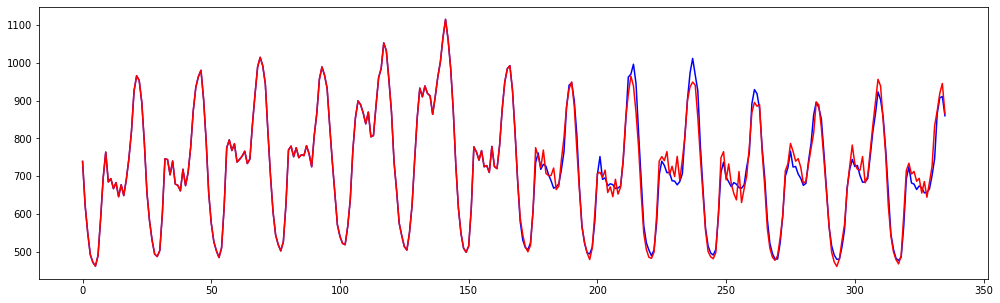

building : 19, score : 2.6948495136584354


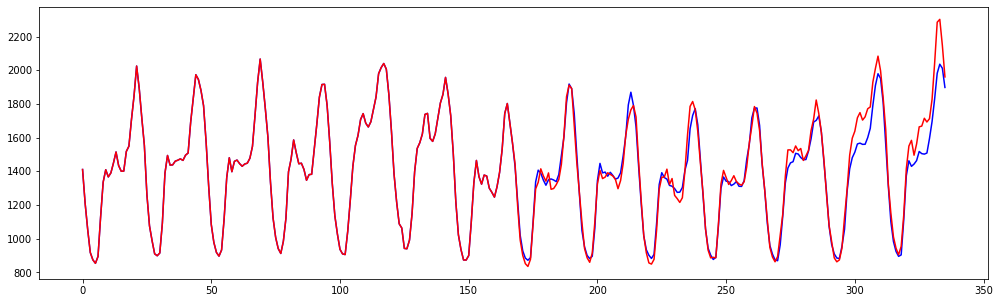

building : 20, score : 3.3201002981357863


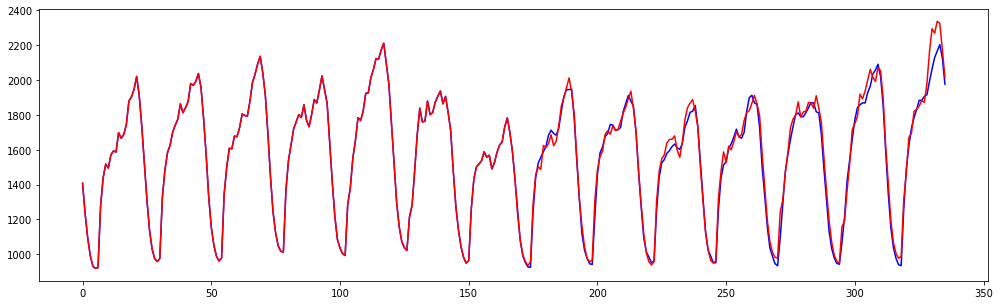

building : 21, score : 2.362599627232786


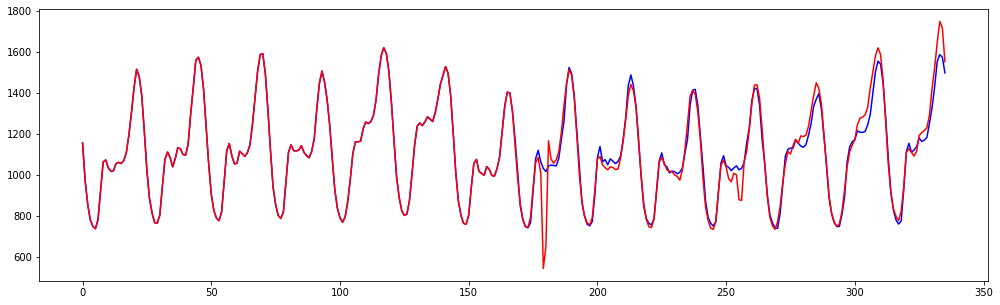

building : 49, score : 3.2407786685743125


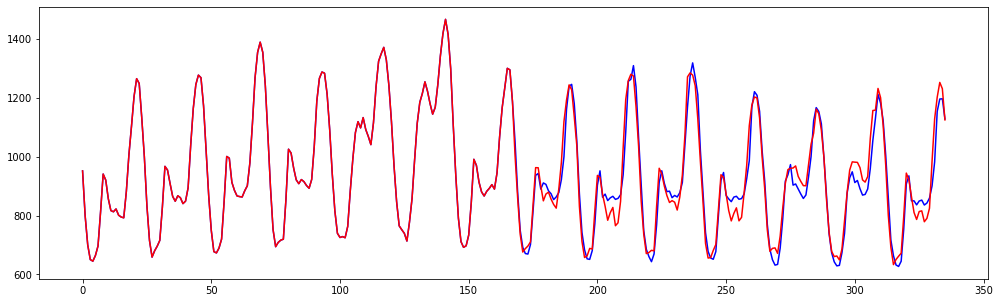

building : 50, score : 3.9202127803278444


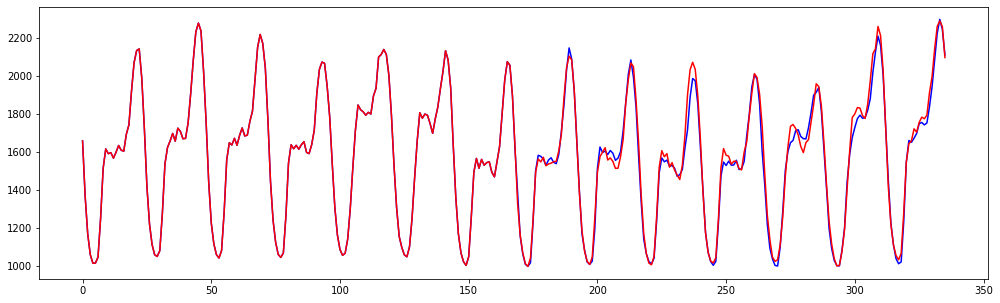

building : 51, score : 1.867488490891033
now group : E4


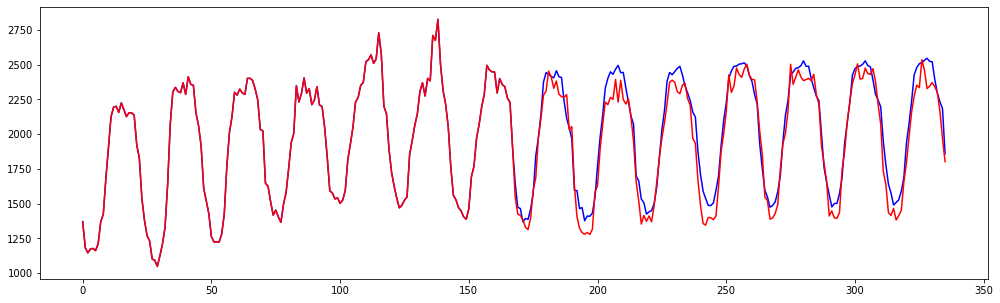

building : 28, score : 4.750403429542566


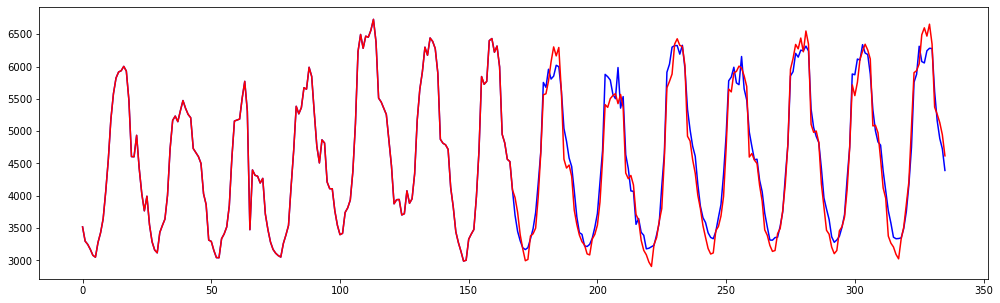

building : 30, score : 3.8811027618756206


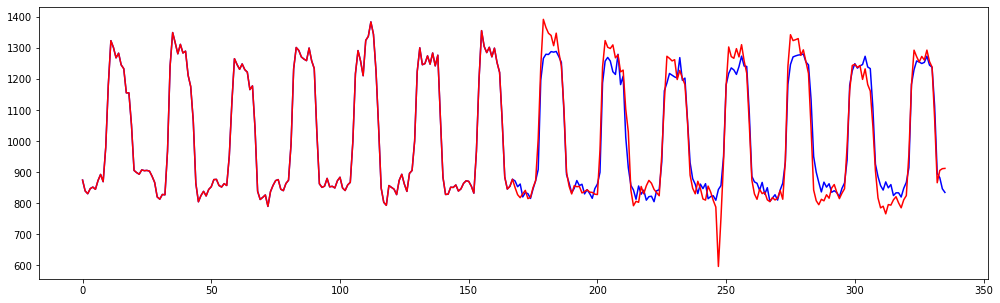

building : 36, score : 3.641739187422332


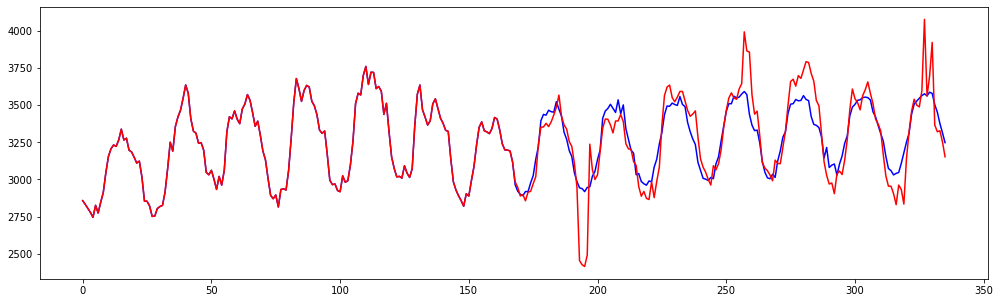

building : 60, score : 3.1366636926715628
now group : E5


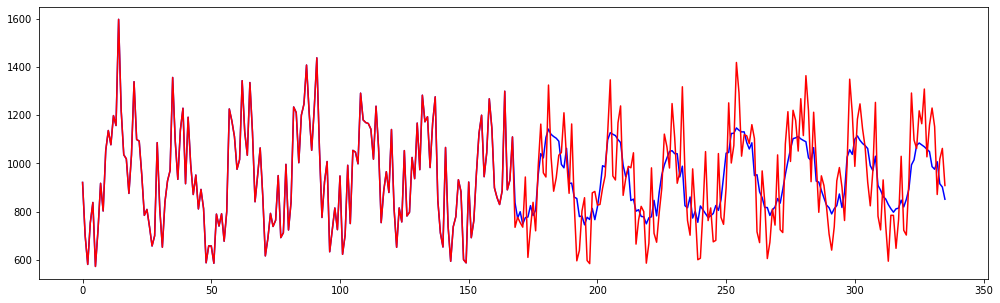

building : 59, score : 12.38322921972621


In [5]:
for i in range(len(model_paths)):
    now_dataframe = dataframes.loc[dataframes["energy_group"] == str(i)].copy()
    
    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    print(f"now group : {group_name[i]}")

    for building in group[i]:
        now_building_dataframe = now_dataframe.loc[now_dataframe["num"] == str(building)].copy()
        now_building_dataframe = now_building_dataframe[start_point:start_point+input_length+duration]

        original = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()
        prediction = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()  

        total_cycle = ((len(now_building_dataframe) - input_length - output_length) // output_length) + 1

        for k in range(total_cycle):
            now_start_point = k*output_length

            encoder_data = now_building_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
            decoder_data = now_building_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

            raw_predictions = now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
            originals = now_building_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

            prediction.extend(raw_predictions)
            original.extend(originals)

            # for next step, change dataframe's original value to predicted value
            for p in range(output_length):
                now_building_dataframe.iloc[now_start_point+input_length+p, now_building_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
            
        if show_graph:
            plt.rcParams["figure.figsize"] = (17,5)
            fig = plt.figure()
            graph = fig.add_subplot(1, 1, 1)
            graph.plot(prediction, color='blue')
            graph.plot(original, color='red')
            plt.show()

        smape_loss = smape(np.array(prediction[168:]), np.array(original[168:]))
        print(f"building : {building}, score : {smape_loss}")
        all_smape.append(smape_loss)
        part_smape[i].append(smape_loss)

        # break
    # break

In [6]:
print("\n")
print(f"selected time slice : {random_choice}")
print(f"totoal score : {np.mean(np.array(all_smape))}")
for i in range(len(group_name)):
    print(f"{group_name[i]} score : {np.mean(np.array(part_smape[i]))}")



selected time slice : 11
totoal score : 4.804191768251441
A1 score : 15.242957951471347
A2 score : 6.305082005844984
A3 score : 4.798859117295338
A4 score : 5.921582730208915
A5 score : 5.792112468552347
A6 score : 11.828601289346386
A7 score : 5.684657299250416
B1 score : 3.621418108278664
B2 score : 4.19424252575806
B3 score : 4.226568731986142
B4 score : 6.737202230669435
B5 score : 2.052841885006671
C1 score : 0.4313179085766262
C2 score : 0.9788603629646397
C3 score : 1.784253615769069
C4 score : 0.23419757808050892
D1 score : 7.344227624675312
D2 score : 9.171708560466264
D3 score : 5.031598894594057
D4 score : 6.430644650789729
D5 score : 4.090946218233237
D6 score : 2.5023808675206656
E1 score : 6.649616093855119
E2 score : 1.4277153275528254
E3 score : 2.901004896470033
E4 score : 3.85247726787802
E5 score : 12.38322921972621
